# Main Analysis: GenAI Impact on Corporate Policy

## Difference-in-Differences & Event Study Analysis

This notebook implements the main empirical analysis:
1. Panel construction (wide to long format)
2. Difference-in-Differences estimation
3. Event study with dynamic treatment effects
4. Robustness checks

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install required packages for panel econometrics
!pip install linearmodels pyfixest -q
print("Packages installed!")

Packages installed!


In [3]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import gc  # Garbage collection for memory management
warnings.filterwarnings('ignore')

# Econometrics
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, PooledOLS
from linearmodels import PanelOLS as PanelFE
import pyfixest as pf

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

# Memory monitoring utility
def print_memory_usage():
    """Print current memory usage of key objects."""
    import sys
    print("\n--- Memory Usage ---")
    for name, obj in list(globals().items()):
        if isinstance(obj, pd.DataFrame):
            size_mb = obj.memory_usage(deep=True).sum() / (1024 * 1024)
            print(f"{name}: {size_mb:.2f} MB ({obj.shape})")
    print("-------------------\n")

DATA_PATH = Path('/content/drive/MyDrive/Paper_2')
print("Libraries loaded (with memory optimization support)!")

Libraries loaded (with memory optimization support)!


## 1. Load Data with AI Exposure

In [4]:
# Try to load processed data, fall back to raw
try:
    df = pd.read_parquet(DATA_PATH / 'data_with_ai_exposure.parquet')
    print(f"Loaded processed data: {df.shape}")
except:
    print("Run notebook 02 first, or loading raw data...")
    df1 = pd.read_excel(DATA_PATH / 'Data_1.xlsx')
    df2 = pd.read_excel(DATA_PATH / 'Data_2.xlsx')

    common_cols = set(df1.columns) & set(df2.columns)
    if common_cols:
        df = pd.merge(df1, df2, on=list(common_cols), how='outer')
    elif len(df1) == len(df2):
        df = pd.concat([df1, df2], axis=1)
    else:
        df = df1
    print(f"Loaded raw data: {df.shape}")

Loaded processed data: (17388, 236)


## 2. Convert Wide to Long Panel Format

Your data is in WIDE format (one row per firm, many time columns).
For panel analysis, we need LONG format (one row per firm-time).

In [5]:
# Identify firm identifier column
# UPDATE THESE BASED ON YOUR ACTUAL COLUMN NAMES
FIRM_ID_COL = None
FIRM_NAME_COL = None

for col in df.columns:
    col_lower = col.lower()
    if 'ticker' in col_lower or 'symbol' in col_lower:
        FIRM_ID_COL = col
    if 'name' in col_lower and 'company' in col_lower:
        FIRM_NAME_COL = col

print(f"Firm ID column: {FIRM_ID_COL}")
print(f"Firm Name column: {FIRM_NAME_COL}")

# Create a simple firm ID if not found
if FIRM_ID_COL is None:
    df['firm_id'] = range(len(df))
    FIRM_ID_COL = 'firm_id'

Firm ID column: Exchange:Ticker
Firm Name column: Company Name


In [6]:
import re

def extract_time_from_column(col_name):
    """
    Extract time period from column name.
    Returns: (base_metric, time_offset, time_type)

    Examples:
    - 'Revenue [LTM]' -> ('Revenue', 0, 'LTM')
    - 'Revenue [LTM - 4]' -> ('Revenue', 4, 'LTM')
    - 'Market Cap [Latest]' -> ('Market Cap', 0, 'Annual')
    - 'Market Cap [Latest - 3 Year(s)]' -> ('Market Cap', 3, 'Annual')
    - 'Cash [Latest Quarter]' -> ('Cash', 0, 'Quarterly')
    - 'Cash [Latest Quarter - 8]' -> ('Cash', 8, 'Quarterly')
    """
    # Pattern for LTM columns
    ltm_pattern = r'(.+?)\s*\[LTM(?:\s*-\s*(\d+))?\]'
    # Pattern for Annual columns
    annual_pattern = r'(.+?)\s*\[Latest(?:\s*-\s*(\d+)\s*Year)?'
    # Pattern for Quarterly columns
    quarterly_pattern = r'(.+?)\s*\[Latest\s*Quarter(?:\s*-\s*(\d+))?\]'

    # Try LTM first
    match = re.search(ltm_pattern, col_name, re.IGNORECASE)
    if match:
        metric = match.group(1).strip()
        offset = int(match.group(2)) if match.group(2) else 0
        return (metric, offset, 'LTM')

    # Try Quarterly
    match = re.search(quarterly_pattern, col_name, re.IGNORECASE)
    if match:
        metric = match.group(1).strip()
        offset = int(match.group(2)) if match.group(2) else 0
        return (metric, offset, 'Quarterly')

    # Try Annual
    match = re.search(annual_pattern, col_name, re.IGNORECASE)
    if match:
        metric = match.group(1).strip()
        offset = int(match.group(2)) if match.group(2) else 0
        return (metric, offset, 'Annual')

    return (col_name, None, None)

# Test the function
test_cols = [
    'Revenue [LTM]',
    'Revenue [LTM - 4]',
    'Market Cap [Latest]',
    'Market Cap [Latest - 3 Year(s)]',
    'Cash [Latest Quarter]',
    'Cash [Latest Quarter - 8]'
]

print("Column parsing test:")
for col in test_cols:
    result = extract_time_from_column(col)
    print(f"  {col:40} -> {result}")

Column parsing test:
  Revenue [LTM]                            -> ('Revenue', 0, 'LTM')
  Revenue [LTM - 4]                        -> ('Revenue', 4, 'LTM')
  Market Cap [Latest]                      -> ('Market Cap', 0, 'Annual')
  Market Cap [Latest - 3 Year(s)]          -> ('Market Cap', 3, 'Annual')
  Cash [Latest Quarter]                    -> ('Cash', 0, 'Quarterly')
  Cash [Latest Quarter - 8]                -> ('Cash', 8, 'Quarterly')


In [7]:
# Parse all columns
column_info = []
for col in df.columns:
    metric, offset, time_type = extract_time_from_column(col)
    column_info.append({
        'original_col': col,
        'metric': metric,
        'time_offset': offset,
        'time_type': time_type
    })

col_df = pd.DataFrame(column_info)
print(f"Total columns: {len(col_df)}")
print(f"\nTime series columns by type:")
print(col_df['time_type'].value_counts(dropna=False))

# Show sample of parsed columns
print("\nSample parsed columns:")
display(col_df[col_df['time_type'].notna()].head(20))

Total columns: 236

Time series columns by type:
time_type
LTM          130
Quarterly     90
Annual        10
None           6
Name: count, dtype: int64

Sample parsed columns:


,original_col,metric,time_offset,time_type
5,Market Capitalization [My Setting] [Latest - 9...,Market Capitalization [My Setting],9.0000,Annual
6,Market Capitalization [My Setting] [Latest - 8...,Market Capitalization [My Setting],8.0000,Annual
7,Market Capitalization [My Setting] [Latest - 7...,Market Capitalization [My Setting],7.0000,Annual
8,Market Capitalization [My Setting] [Latest - 6...,Market Capitalization [My Setting],6.0000,Annual
9,Market Capitalization [My Setting] [Latest - 5...,Market Capitalization [My Setting],5.0000,Annual
10,Market Capitalization [My Setting] [Latest - 4...,Market Capitalization [My Setting],4.0000,Annual
11,Market Capitalization [My Setting] [Latest - 3...,Market Capitalization [My Setting],3.0000,Annual
12,Market Capitalization [My Setting] [Latest - 2...,Market Capitalization [My Setting],2.0000,Annual
13,Market Capitalization [My Setting] [Latest - 1...,Market Capitalization [My Setting],1.0000,Annual
14,Market Capitalization [My Setting] [Latest] ($...,Market Capitalization [My Setting],0.0000,Annual


In [8]:
import gc

def wide_to_long_panel(df, firm_id_col, col_df, time_type='LTM'):
    """
    Convert wide format to long panel format.
    MEMORY OPTIMIZED: Uses chunked processing and explicit garbage collection.

    Parameters:
    -----------
    df : DataFrame in wide format
    firm_id_col : column name for firm identifier
    col_df : DataFrame with column parsing info
    time_type : 'LTM', 'Quarterly', or 'Annual'

    Returns:
    --------
    DataFrame in long format (firm_id, time, metric1, metric2, ...)
    """
    # Filter to relevant time type
    time_cols = col_df[col_df['time_type'] == time_type].copy()

    if len(time_cols) == 0:
        print(f"No columns found for time_type={time_type}")
        return None

    # Get unique time offsets
    time_offsets = sorted(time_cols['time_offset'].unique())
    print(f"Time offsets found: {time_offsets}")

    # Get unique metrics
    metrics = time_cols['metric'].unique()
    print(f"Metrics found: {len(metrics)}")

    # MEMORY OPTIMIZATION: Process and concatenate incrementally
    # Instead of building a list of all DataFrames, concatenate in batches
    panel = None

    for i, offset in enumerate(time_offsets):
        # Get columns for this time period
        period_cols = time_cols[time_cols['time_offset'] == offset]

        # Create mapping from original column to metric name
        col_mapping = dict(zip(period_cols['original_col'], period_cols['metric']))

        # Select and rename columns
        cols_to_select = [firm_id_col] + list(col_mapping.keys())
        cols_available = [c for c in cols_to_select if c in df.columns]

        if len(cols_available) <= 1:
            continue

        # Create period DataFrame with only necessary columns
        period_df = df[cols_available].rename(columns=col_mapping)
        period_df['time_offset'] = offset

        # Incremental concatenation
        if panel is None:
            panel = period_df
        else:
            panel = pd.concat([panel, period_df], ignore_index=True)
            # Explicitly delete period_df and collect garbage every few iterations
            del period_df
            if i % 3 == 0:
                gc.collect()

    if panel is None:
        return None

    # Sort by firm and time
    panel = panel.sort_values([firm_id_col, 'time_offset'])

    # Force garbage collection after processing
    gc.collect()

    return panel

# Create panel for LTM metrics (quarterly frequency)
panel_ltm = wide_to_long_panel(df, FIRM_ID_COL, col_df, time_type='LTM')
if panel_ltm is not None:
    print(f"\nLTM Panel shape: {panel_ltm.shape}")
    display(panel_ltm.head())

Time offsets found: [np.float64(0.0), np.float64(4.0), np.float64(8.0), np.float64(12.0), np.float64(16.0), np.float64(20.0), np.float64(24.0), np.float64(28.0), np.float64(32.0), np.float64(36.0)]
Metrics found: 13

LTM Panel shape: (173880, 15)


,Exchange:Ticker,Gross Profit - Capital IQ,Operating Income - Capital IQ,EBITDA - Capital IQ,Net Income - Capital IQ,R&D Expense - Compustat,Interest Expense - Capital IQ,Common Dividends - Compustat,Capital Expenditures - Compustat,Acquisitions - Compustat,Return on Assets % - Compustat,Return on Equity % - Compustat,Total Debt/Equity - Compustat,Revenue - Compustat,time_offset
11,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
14,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
17,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
33,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
35,-,NaN,NaN,NaN,NaN,0.0000,NaN,0.0000,-8.0000,0.0000,1.1300,6.5200,220.6000,9661.0000,0.0000


In [9]:
# Also create quarterly balance sheet panel
panel_quarterly = wide_to_long_panel(df, FIRM_ID_COL, col_df, time_type='Quarterly')
if panel_quarterly is not None:
    print(f"\nQuarterly Panel shape: {panel_quarterly.shape}")
    display(panel_quarterly.head())

Time offsets found: [np.float64(0.0), np.float64(4.0), np.float64(8.0), np.float64(12.0), np.float64(16.0), np.float64(20.0), np.float64(24.0), np.float64(28.0), np.float64(32.0), np.float64(36.0)]
Metrics found: 9

Quarterly Panel shape: (173880, 11)


,Exchange:Ticker,Cash & Short-Term Investments - Compustat,Total Receivables - Compustat,Total Inventories - Compustat,Total Current Assets - Compustat,"Gross Property, Plant & Equipment - Compustat",Total Assets - Compustat,Total Current Debt - Compustat,Total Employees - Compustat,Long-Term Debt - Compustat,time_offset
11,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,0.0000
14,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,0.0000
17,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,0.0000
33,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,0.0000
35,-,39681.0000,62780.0000,600.0000,103061.0000,0.0000,172441.0000,7564.0000,-,20668.0000,0.0000


In [10]:
# Merge panels if both exist
# MEMORY OPTIMIZED: Uses index-based concat instead of pd.merge()

print(f"panel_ltm exists: {panel_ltm is not None}")
print(f"panel_quarterly exists: {panel_quarterly is not None}")

if panel_ltm is not None and panel_quarterly is not None:
    print(f"panel_ltm shape: {panel_ltm.shape}")
    print(f"panel_quarterly shape: {panel_quarterly.shape}")

    # MEMORY OPTIMIZATION: Use index-based concat instead of merge
    # Since both panels have the same firms and time periods, we can:
    # 1. Set index on both DataFrames
    # 2. Use concat on axis=1 (columns) - this is MUCH more memory efficient

    # Step 1: Set index on both DataFrames (this creates views, not copies)
    panel_ltm_indexed = panel_ltm.set_index([FIRM_ID_COL, 'time_offset'])
    panel_quarterly_indexed = panel_quarterly.set_index([FIRM_ID_COL, 'time_offset'])

    # Step 2: Delete original DataFrames immediately to free memory
    del panel_ltm
    del panel_quarterly
    gc.collect()
    print("Freed original panel DataFrames before concat")

    # Step 3: Use concat on axis=1 - much more memory efficient than merge
    # This directly combines columns without creating intermediate merge keys
    panel = pd.concat([panel_ltm_indexed, panel_quarterly_indexed], axis=1)

    # Step 4: Reset index to get firm_id and time_offset back as columns
    panel = panel.reset_index()

    # Step 5: Clean up indexed DataFrames
    del panel_ltm_indexed
    del panel_quarterly_indexed
    gc.collect()

    print(f"Merged panel shape: {panel.shape}")
    print("Memory-efficient merge completed!")

elif panel_ltm is not None:
    panel = panel_ltm
    del panel_ltm  # Remove reference to allow gc
    gc.collect()
    print(f"Using LTM panel only: {panel.shape}")
elif panel_quarterly is not None:
    panel = panel_quarterly
    del panel_quarterly  # Remove reference to allow gc
    gc.collect()
    print(f"Using Quarterly panel only: {panel.shape}")
else:
    raise ValueError("No panel data available! Please run cells 10 and 11 first to create panel_ltm and panel_quarterly.")

print(f"Final panel shape: {panel.shape}")
print(f"Panel columns: {list(panel.columns)}")

panel_ltm exists: True
panel_quarterly exists: True
panel_ltm shape: (173880, 15)
panel_quarterly shape: (173880, 11)
Freed original panel DataFrames before concat
Merged panel shape: (173880, 24)
Memory-efficient merge completed!
Final panel shape: (173880, 24)
Panel columns: ['Exchange:Ticker', 'time_offset', 'Gross Profit - Capital IQ', 'Operating Income - Capital IQ', 'EBITDA - Capital IQ', 'Net Income - Capital IQ', 'R&D Expense - Compustat', 'Interest Expense - Capital IQ', 'Common Dividends - Compustat', 'Capital Expenditures - Compustat', 'Acquisitions - Compustat', 'Return on Assets % - Compustat', 'Return on Equity % - Compustat', 'Total Debt/Equity - Compustat', 'Revenue - Compustat', 'Cash & Short-Term Investments - Compustat', 'Total Receivables - Compustat', 'Total Inventories - Compustat', 'Total Current Assets - Compustat', 'Gross Property, Plant & Equipment - Compustat', 'Total Assets - Compustat', 'Total Current Debt - Compustat', 'Total Employees - Compustat', 'Long-

## 3. Add Treatment Variables and Time Indicators

In [11]:
# Merge AI exposure to panel - MEMORY OPTIMIZED VERSION
# Uses mapping instead of pd.merge to avoid memory spike

import gc

print("Starting memory-optimized merge of static columns...")

# Force garbage collection before starting
gc.collect()

# Get static firm characteristics from original df
static_cols = [FIRM_ID_COL]

# Add AI exposure columns if they exist
for col in ['ai_exposure', 'ai_exposure_binary', 'ai_exposure_continuous']:
    if col in df.columns:
        static_cols.append(col)

# Add identifier columns
for col in df.columns:
    col_lower = col.lower()
    if any(kw in col_lower for kw in ['industry', 'sector', 'country', 'exchange', 'type']):
        if col not in static_cols:
            static_cols.append(col)

print(f"Static columns to merge: {static_cols}")
print(f"Panel shape before merge: {panel.shape}")

# MEMORY OPTIMIZATION: Use map() instead of merge()
# This is MUCH more memory efficient for simple key lookups

# First, create a mapping DataFrame with only unique firms
# Drop duplicates immediately to minimize memory
firm_ids = df[FIRM_ID_COL].values  # Get firm IDs as numpy array

# Process each column individually using map() - avoids large intermediate DataFrames
for col in static_cols:
    if col == FIRM_ID_COL:
        continue  # Skip the ID column itself

    if col not in panel.columns:  # Only add if not already present
        # Create a mapping dict for this column
        # Using dict comprehension is memory efficient
        col_mapping = dict(zip(firm_ids, df[col].values))

        # Map values to panel - this is much faster and uses less memory than merge
        panel[col] = panel[FIRM_ID_COL].map(col_mapping)

        # Clear the mapping dict
        del col_mapping

        # Garbage collect periodically
        gc.collect()

        print(f"  Added column: {col}")

print(f"Panel shape after merge: {panel.shape}")

# MEMORY OPTIMIZATION: Delete original df now that we're done with it
# The original wide-format df is no longer needed
del df
gc.collect()
print("Cleaned up original DataFrame - using panel data only from now on")

# Optimize panel dtypes to save memory
print("\nOptimizing panel dtypes...")

# Convert object columns with few unique values to category
for col in panel.select_dtypes(include=['object']).columns:
    n_unique = panel[col].nunique()
    if n_unique < 1000:  # Convert to category if < 1000 unique values
        panel[col] = panel[col].astype('category')
        print(f"  Converted {col} to category ({n_unique} unique values)")

# Downcast numeric columns
for col in panel.select_dtypes(include=['float64']).columns:
    panel[col] = pd.to_numeric(panel[col], downcast='float')

for col in panel.select_dtypes(include=['int64']).columns:
    panel[col] = pd.to_numeric(panel[col], downcast='integer')

gc.collect()
print(f"\nFinal panel memory usage: {panel.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Starting memory-optimized merge of static columns...
Static columns to merge: ['Exchange:Ticker', 'ai_exposure', 'Company Type', 'Industry Classifications']
Panel shape before merge: (173880, 24)
  Added column: ai_exposure
  Added column: Company Type
  Added column: Industry Classifications
Panel shape after merge: (173880, 27)
Cleaned up original DataFrame - using panel data only from now on

Optimizing panel dtypes...
  Converted Total Employees - Compustat to category (1 unique values)
  Converted Company Type to category (1 unique values)
  Converted Industry Classifications to category (11 unique values)

Final panel memory usage: 32.22 MB


In [ ]:
# Convert time_offset to actual calendar time
# IMPORTANT: Update BASE_DATE based on when "Latest" refers to in your data

# Assuming "Latest" = most recent available (e.g., Q4 2024 or Q3 2024)
# UPDATE THIS based on your data
BASE_YEAR = 2024
BASE_QUARTER = 4  # Q4

def offset_to_quarter(offset, base_year, base_quarter):
    """
    Convert quarter offset to (year, quarter).
    offset=0 is the base period, offset=4 is 1 year ago, etc.
    """
    total_quarters = base_year * 4 + base_quarter - offset
    year = (total_quarters - 1) // 4
    quarter = ((total_quarters - 1) % 4) + 1
    return year, quarter

# Apply to panel
panel['year'], panel['quarter'] = zip(*panel['time_offset'].apply(
    lambda x: offset_to_quarter(x, BASE_YEAR, BASE_QUARTER)
))

# Create period identifier (e.g., 2022Q4) - for display purposes
panel['period_str'] = panel['year'].astype(str) + 'Q' + panel['quarter'].astype(str)

# FIXED: Create NUMERIC period identifier for PanelOLS
# yearquarter = year * 4 + quarter (e.g., 2022Q4 = 2022*4+4 = 8092)
panel['period'] = panel['year'] * 4 + panel['quarter']
panel['yearquarter'] = panel['period']  # Alias for compatibility

# Create datetime for plotting
panel['date'] = pd.to_datetime(panel['year'].astype(str) + '-' +
                                ((panel['quarter']-1)*3 + 1).astype(str) + '-01')

print("Time periods in panel:")
print(panel[['time_offset', 'year', 'quarter', 'period_str', 'period']].drop_duplicates().sort_values('time_offset'))
print(f"\nPeriod column type: {panel['period'].dtype}")
print("✓ Period is now numeric (year*4+quarter) for PanelOLS compatibility")

In [13]:
# Create POST indicator (after ChatGPT release Nov 2022)
# ChatGPT released Nov 30, 2022 -> first full quarter is Q1 2023
CHATGPT_RELEASE_YEAR = 2022
CHATGPT_RELEASE_QUARTER = 4  # Q4 2022 is the shock quarter

panel['post_chatgpt'] = ((panel['year'] > CHATGPT_RELEASE_YEAR) |
                          ((panel['year'] == CHATGPT_RELEASE_YEAR) &
                           (panel['quarter'] > CHATGPT_RELEASE_QUARTER))).astype(int)

# Alternative: include Q4 2022 as post
panel['post_chatgpt_inclusive'] = ((panel['year'] > CHATGPT_RELEASE_YEAR) |
                                    ((panel['year'] == CHATGPT_RELEASE_YEAR) &
                                     (panel['quarter'] >= CHATGPT_RELEASE_QUARTER))).astype(int)

print(f"\nPost-ChatGPT observations (exclusive): {panel['post_chatgpt'].sum()} / {len(panel)}")
print(f"Post-ChatGPT observations (inclusive): {panel['post_chatgpt_inclusive'].sum()} / {len(panel)}")


Post-ChatGPT observations (exclusive): 34776 / 173880
Post-ChatGPT observations (inclusive): 52164 / 173880


In [14]:
# Create event time variable for event study
# Event time = quarters relative to Q4 2022
event_quarter = CHATGPT_RELEASE_YEAR * 4 + CHATGPT_RELEASE_QUARTER
panel['event_time'] = (panel['year'] * 4 + panel['quarter']) - event_quarter

print("Event time distribution:")
print(panel['event_time'].value_counts().sort_index())

Event time distribution:
event_time
-28.0000    17388
-24.0000    17388
-20.0000    17388
-16.0000    17388
-12.0000    17388
-8.0000     17388
-4.0000     17388
0.0000      17388
4.0000      17388
8.0000      17388
Name: count, dtype: int64


In [15]:
# Create DiD interaction term
treatment_col = 'ai_exposure_binary' if 'ai_exposure_binary' in panel.columns else 'ai_exposure'

if treatment_col in panel.columns:
    panel['treated_x_post'] = panel[treatment_col] * panel['post_chatgpt']
    print(f"DiD interaction (Treated × Post):")
    print(panel['treated_x_post'].value_counts())
else:
    print(f"Treatment column not found. Run notebook 02 first.")

DiD interaction (Treated × Post):
treated_x_post
0    163560
1     10320
Name: count, dtype: int64


## 4. Summary Statistics

In [16]:
# Find outcome variables
outcome_candidates = ['Revenue', 'EBITDA', 'Net Income', 'Operating Income',
                      'R&D', 'CapEx', 'Employee', 'Cash', 'Total Debt']

outcome_cols = []
for col in panel.columns:
    for candidate in outcome_candidates:
        if candidate.lower() in col.lower():
            outcome_cols.append(col)
            break

outcome_cols = list(set(outcome_cols))
print(f"Outcome variables found: {outcome_cols}")

Outcome variables found: ['Operating Income - Capital IQ', 'EBITDA - Capital IQ', 'R&D Expense - Compustat', 'Total Employees - Compustat', 'Net Income - Capital IQ', 'Revenue - Compustat', 'Total Debt/Equity - Compustat', 'Cash & Short-Term Investments - Compustat']


In [17]:
# Summary statistics by treatment group
if treatment_col in panel.columns and len(outcome_cols) > 0:
    # Pre-period statistics
    pre_period = panel[panel['post_chatgpt'] == 0]

    print("Summary Statistics: Pre-ChatGPT Period")
    print("=" * 80)

    summary_data = []
    for col in outcome_cols[:10]:  # First 10 outcomes
        if col in pre_period.columns:
            treated = pre_period[pre_period[treatment_col] == 1][col]
            control = pre_period[pre_period[treatment_col] == 0][col]

            summary_data.append({
                'Variable': col[:40],
                'Treated Mean': treated.mean(),
                'Treated SD': treated.std(),
                'Control Mean': control.mean(),
                'Control SD': control.std(),
                'Diff': treated.mean() - control.mean()
            })

    summary_df = pd.DataFrame(summary_data)
    display(summary_df)

Summary Statistics: Pre-ChatGPT Period


TypeError: 'Categorical' with dtype category does not support reduction 'mean'

## 5. Parallel Trends Visualization

KeyError: 'date'

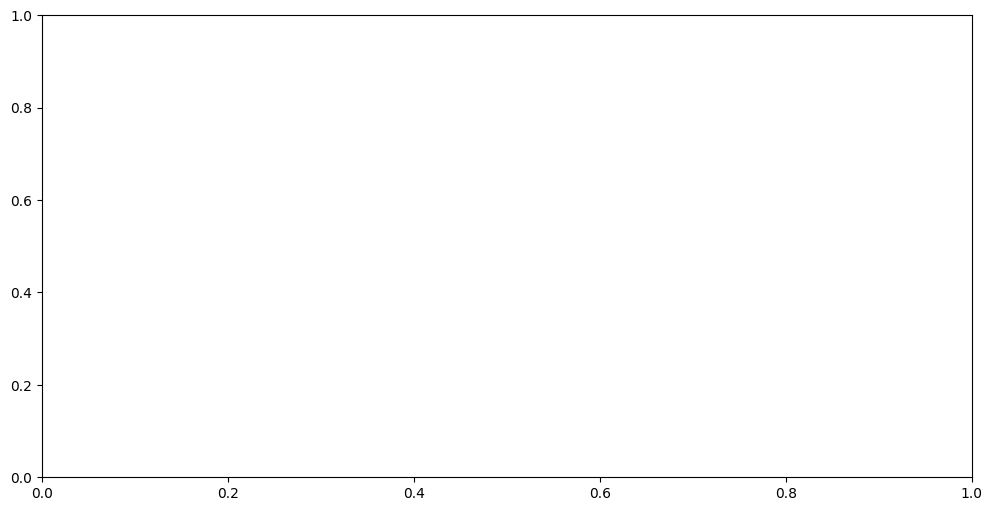

In [18]:
def plot_parallel_trends(panel, outcome_col, treatment_col, date_col='date',
                         event_date='2022-11-01', title=None):
    """
    Plot parallel trends for treatment and control groups.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Group by time and treatment
    trends = panel.groupby([date_col, treatment_col])[outcome_col].mean().reset_index()

    # Plot each group
    for treat_val in [0, 1]:
        group_data = trends[trends[treatment_col] == treat_val]
        label = 'High AI Exposure' if treat_val == 1 else 'Low AI Exposure'
        color = 'steelblue' if treat_val == 1 else 'coral'
        ax.plot(group_data[date_col], group_data[outcome_col],
                marker='o', label=label, color=color, linewidth=2)

    # Add vertical line for event
    ax.axvline(pd.to_datetime(event_date), color='red', linestyle='--',
               label='ChatGPT Release', alpha=0.7)

    ax.set_xlabel('Date')
    ax.set_ylabel(outcome_col)
    ax.set_title(title or f'Parallel Trends: {outcome_col}')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Plot for key outcomes
if treatment_col in panel.columns and len(outcome_cols) > 0:
    for outcome in outcome_cols[:4]:
        if outcome in panel.columns and panel[outcome].notna().sum() > 100:
            fig = plot_parallel_trends(panel, outcome, treatment_col)
            plt.show()

## 6. Difference-in-Differences Estimation

In [19]:
def run_did_regression(panel, outcome, treatment_col, firm_id,
                       time_var='period', cluster_var=None):
    """
    Run DiD regression with firm and time fixed effects.
    MEMORY OPTIMIZED: Avoids unnecessary DataFrame copies.

    Y_it = α_i + α_t + β(Treated_i × Post_t) + ε_it
    """
    # MEMORY OPTIMIZATION: Select only needed columns and drop NA in one step
    needed_cols = [firm_id, time_var, outcome, treatment_col, 'post_chatgpt', 'treated_x_post']
    reg_data = panel[needed_cols].dropna()  # dropna returns a view when possible

    if len(reg_data) < 100:
        print(f"Insufficient observations for {outcome}: {len(reg_data)}")
        return None

    # Set index for panel (this creates a view, not a copy)
    reg_data = reg_data.set_index([firm_id, time_var])

    # Define variables - use views where possible
    y = reg_data[outcome]
    X = reg_data[['treated_x_post']]
    X = sm.add_constant(X)

    # Run regression with fixed effects
    try:
        model = PanelOLS(y, X, entity_effects=True, time_effects=True)
        results = model.fit(cov_type='clustered', cluster_entity=True)

        # Clean up after regression
        del reg_data, y, X
        gc.collect()

        return results
    except Exception as e:
        print(f"Error running regression for {outcome}: {e}")
        return None

print("DiD regression function defined (memory optimized).")

DiD regression function defined (memory optimized).


In [20]:
# Run DiD for each outcome
did_results = {}

if 'treated_x_post' in panel.columns:
    for outcome in outcome_cols[:8]:  # First 8 outcomes
        if outcome in panel.columns:
            print(f"\n{'='*60}")
            print(f"Outcome: {outcome}")
            print('='*60)

            result = run_did_regression(panel, outcome, treatment_col, FIRM_ID_COL)
            if result:
                did_results[outcome] = result
                print(result.summary.tables[1])


Outcome: Operating Income - Capital IQ
Error running regression for Operating Income - Capital IQ: The index on the time dimension must be either numeric or date-like

Outcome: EBITDA - Capital IQ
Error running regression for EBITDA - Capital IQ: The index on the time dimension must be either numeric or date-like

Outcome: R&D Expense - Compustat
Error running regression for R&D Expense - Compustat: The index on the time dimension must be either numeric or date-like

Outcome: Total Employees - Compustat
Error running regression for Total Employees - Compustat: The index on the time dimension must be either numeric or date-like

Outcome: Net Income - Capital IQ
Error running regression for Net Income - Capital IQ: The index on the time dimension must be either numeric or date-like

Outcome: Revenue - Compustat
Error running regression for Revenue - Compustat: The index on the time dimension must be either numeric or date-like

Outcome: Total Debt/Equity - Compustat
Error running regres

In [ ]:
# Alternative: Use pyfixest for faster/simpler syntax
# FIXED: Handle column names with spaces/special characters

if 'treated_x_post' in panel.columns and len(outcome_cols) > 0:
    outcome = outcome_cols[0]

    # Prepare for pyfixest
    reg_df = panel[[FIRM_ID_COL, 'period', outcome, 'treated_x_post']].dropna().copy()
    reg_df['firm_fe'] = reg_df[FIRM_ID_COL].astype('category')
    reg_df['time_fe'] = reg_df['period'].astype('category')
    
    # FIXED: Create clean variable name for outcome (no spaces or special chars)
    # Pyfixest formulas don't handle column names with spaces well
    clean_outcome_name = 'outcome_var'
    reg_df[clean_outcome_name] = reg_df[outcome]

    try:
        # Two-way fixed effects regression with clean variable name
        fit = pf.feols(f"{clean_outcome_name} ~ treated_x_post | firm_fe + time_fe",
                       data=reg_df, vcov={'CRV1': 'firm_fe'})
        print(f"\nPyFixest Results for: {outcome}")
        print(fit.summary())
    except Exception as e:
        print(f"Pyfixest error: {e}")
        print("Falling back to linearmodels PanelOLS...")

## 7. Event Study

In [22]:
def run_event_study(panel, outcome, treatment_col, firm_id, event_time_col='event_time',
                    omit_period=-1, min_period=-12, max_period=8):
    """
    Run event study regression.
    MEMORY OPTIMIZED: Avoids unnecessary DataFrame copies.

    Y_it = α_i + α_t + Σ_k β_k (Treated_i × 1{t=k}) + ε_it

    Omit period -1 (one quarter before) as reference.
    """
    # MEMORY OPTIMIZATION: Select only needed columns first
    needed_cols = [firm_id, 'period', event_time_col, outcome, treatment_col]
    reg_data = panel[needed_cols].dropna()

    # Filter to event window
    mask = (reg_data[event_time_col] >= min_period) & (reg_data[event_time_col] <= max_period)
    reg_data = reg_data.loc[mask]

    if len(reg_data) < 100:
        print(f"Insufficient observations for {outcome}")
        return None

    # Create event time dummies interacted with treatment
    event_times = sorted(reg_data[event_time_col].unique())

    # MEMORY OPTIMIZATION: Create interaction columns in-place
    interact_cols = []
    for t in event_times:
        if t != omit_period:
            col_name = f'treat_x_t{int(t)}'
            reg_data[col_name] = ((reg_data[event_time_col] == t).astype('int8') *
                                   reg_data[treatment_col].astype('int8'))
            interact_cols.append(col_name)

    # Set index
    reg_data_indexed = reg_data.set_index([firm_id, 'period'])

    # Run regression
    y = reg_data_indexed[outcome]
    X = reg_data_indexed[interact_cols]
    X = sm.add_constant(X)

    try:
        model = PanelOLS(y, X, entity_effects=True, time_effects=True)
        results = model.fit(cov_type='clustered', cluster_entity=True)

        # Extract coefficients for plotting
        coefs = []
        for t in event_times:
            if t == omit_period:
                coefs.append({'event_time': t, 'coef': 0, 'se': 0, 'ci_low': 0, 'ci_high': 0})
            else:
                col_name = f'treat_x_t{int(t)}'
                if col_name in results.params.index:
                    coef = results.params[col_name]
                    se = results.std_errors[col_name]
                    coefs.append({
                        'event_time': t,
                        'coef': coef,
                        'se': se,
                        'ci_low': coef - 1.96 * se,
                        'ci_high': coef + 1.96 * se
                    })

        coef_df = pd.DataFrame(coefs)

        # Clean up
        del reg_data, reg_data_indexed, y, X
        gc.collect()

        return results, coef_df

    except Exception as e:
        print(f"Error in event study: {e}")
        return None

print("Event study function defined (memory optimized).")

Event study function defined (memory optimized).


In [23]:
def plot_event_study(coef_df, outcome_name, save_path=None):
    """
    Create publication-quality event study plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot confidence intervals
    ax.fill_between(coef_df['event_time'], coef_df['ci_low'], coef_df['ci_high'],
                    alpha=0.2, color='steelblue')

    # Plot point estimates
    ax.plot(coef_df['event_time'], coef_df['coef'], 'o-',
            color='steelblue', linewidth=2, markersize=8)

    # Reference lines
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1,
               label='ChatGPT Release (Q4 2022)')

    # Labels
    ax.set_xlabel('Quarters Relative to ChatGPT Release', fontsize=12)
    ax.set_ylabel(f'Effect on {outcome_name}', fontsize=12)
    ax.set_title(f'Event Study: Effect of AI Exposure on {outcome_name}', fontsize=14)

    # Grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

print("Event study plotting function defined.")

Event study plotting function defined.


In [24]:
# Run event study for key outcomes
event_study_results = {}

if treatment_col in panel.columns:
    for outcome in outcome_cols[:4]:  # First 4 outcomes
        if outcome in panel.columns and panel[outcome].notna().sum() > 100:
            print(f"\n{'='*60}")
            print(f"Event Study: {outcome}")
            print('='*60)

            result = run_event_study(panel, outcome, treatment_col, FIRM_ID_COL)

            if result:
                model_result, coef_df = result
                event_study_results[outcome] = {'model': model_result, 'coefs': coef_df}

                # Plot
                fig = plot_event_study(coef_df, outcome)
                plt.show()


Event Study: Operating Income - Capital IQ
Error in event study: The index on the time dimension must be either numeric or date-like

Event Study: EBITDA - Capital IQ
Error in event study: The index on the time dimension must be either numeric or date-like

Event Study: R&D Expense - Compustat
Error in event study: The index on the time dimension must be either numeric or date-like

Event Study: Total Employees - Compustat
Error in event study: The index on the time dimension must be either numeric or date-like


## 8. Robustness Checks

In [25]:
# Robustness 1: Different clustering (industry level)
print("Robustness checks to implement:")
print("1. Industry-level clustering")
print("2. Continuous treatment measure")
print("3. Alternative event windows")
print("4. Placebo test with fake event dates")
print("5. Exclude specific industries")
print("6. Control for COVID effects")

Robustness checks to implement:
1. Industry-level clustering
2. Continuous treatment measure
3. Alternative event windows
4. Placebo test with fake event dates
5. Exclude specific industries
6. Control for COVID effects


In [26]:
# Robustness 2: Continuous treatment
if 'ai_exposure_continuous' in panel.columns:
    panel['continuous_treat_x_post'] = panel['ai_exposure_continuous'] * panel['post_chatgpt']

    print("\nContinuous Treatment DiD:")
    for outcome in outcome_cols[:3]:
        if outcome in panel.columns:
            # MEMORY OPTIMIZATION: Select only needed columns
            needed_cols = [FIRM_ID_COL, 'period', outcome, 'continuous_treat_x_post']
            reg_data = panel[needed_cols].dropna()

            if len(reg_data) > 100:
                reg_data = reg_data.set_index([FIRM_ID_COL, 'period'])
                y = reg_data[outcome]
                X = sm.add_constant(reg_data[['continuous_treat_x_post']])

                model = PanelOLS(y, X, entity_effects=True, time_effects=True)
                result = model.fit(cov_type='clustered', cluster_entity=True)

                print(f"\n{outcome}:")
                coef = result.params['continuous_treat_x_post']
                se = result.std_errors['continuous_treat_x_post']
                print(f"  Coefficient: {coef:.4f} (SE: {se:.4f})")

                # Clean up after each regression
                del reg_data, y, X, result
                gc.collect()

## 9. Save Results

In [27]:
# Save panel data
panel.to_parquet(DATA_PATH / 'panel_data_analysis.parquet', index=False)
print(f"Panel data saved to: {DATA_PATH / 'panel_data_analysis.parquet'}")

# Save event study coefficients
if event_study_results:
    all_coefs = []
    for outcome, results in event_study_results.items():
        coef_df = results['coefs'].copy()
        coef_df['outcome'] = outcome
        all_coefs.append(coef_df)

    if all_coefs:
        all_coefs_df = pd.concat(all_coefs, ignore_index=True)
        all_coefs_df.to_csv(DATA_PATH / 'event_study_coefficients.csv', index=False)
        print(f"Event study coefficients saved to: {DATA_PATH / 'event_study_coefficients.csv'}")

Panel data saved to: /content/drive/MyDrive/Paper_2/panel_data_analysis.parquet


## 10. Summary & Next Steps

### Key Findings:
1. [To be filled after running]
2. [To be filled after running]

### Next Steps:
1. Run robustness checks in detail
2. Add heterogeneity analysis (by firm size, financial constraints)
3. Create publication-ready tables and figures
4. Write up results section

In [28]:
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"\nTotal firms: {panel[FIRM_ID_COL].nunique():,}")
print(f"Total observations: {len(panel):,}")
print(f"Time periods: {panel['period'].nunique()}")
print(f"\nDiD regressions run: {len(did_results)}")
print(f"Event studies run: {len(event_study_results)}")

# Final memory cleanup
print("\nFinal memory status:")
print_memory_usage()

# Force garbage collection
gc.collect()
print("Garbage collection complete.")


ANALYSIS COMPLETE

Total firms: 7,736
Total observations: 173,880
Time periods: 10

DiD regressions run: 0
Event studies run: 0

Final memory status:

--- Memory Usage ---
col_df: 0.06 MB ((236, 4))
panel: 49.96 MB ((173880, 34))
pre_period: 41.03 MB ((139104, 34))
reg_df: 6.84 MB ((46420, 6))
-------------------

Garbage collection complete.
